# DQN

The goal of this exercise is to implement DQN and to apply it to the cartpole balancing problem. 

In [3]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame moviepy
    !pip install git+https://github.com/thu-ml/tianshou.git@master

In [4]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from collections import deque

import gymnasium as gym
print("gym version:", gym.__version__)

import tianshou as ts

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import pygame
from moviepy.editor import ImageSequenceClip, ipython_display


class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

def running_average(x, N):
    kernel = np.ones(N) / N
    return np.convolve(x, kernel, mode='same')

gym version: 0.28.1


/Users/vitay/.virtualenvs/tianshou/lib/python3.11/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


## Cartpole balancing task

We are going to use the Cartpole balancing problem, which can be loaded with:

```python
gym.make('CartPole-v0')
```

States have 4 continuous values (position and speed of the cart, angle and speed of the pole) and 2 discrete outputs (going left or right). The reward is +1 for each transition where the pole is still standing (angle of less than 30° with the vertical). 

In CartPole-v0, the episode ends when the pole fails or after 200 steps. In CartPole-v1, the maximum episode length is 500 steps, which is too long for us, so we stick to v0 here.

The maximal (undiscounted) return is therefore 200. Can DQN learn this?

Return: 38.0
MoviePy - Building file videos/cartpole.gif with imageio.



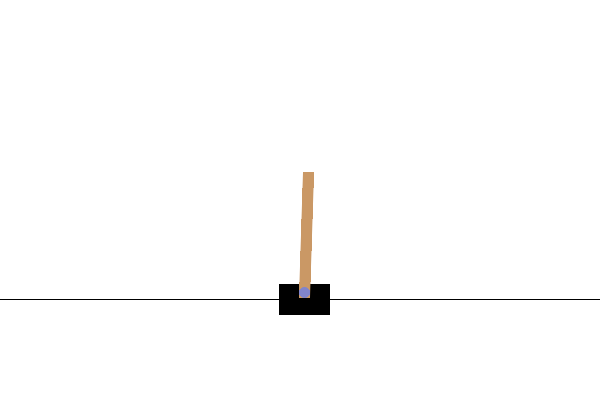

In [5]:
# Create the environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward
    
    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole.gif"
recorder.make_video(video)
ipython_display(video)

As the problem is quite simple (4 state variables, 2 actions), DQN can run on a single CPU. However, we advise that you run the notebook on a GPU in Colab to avoid emptying the battery of your laptop too fast or making it too warm as training takes quite a long time.

## Tianshou framework

In [6]:
env_name = "CartPole-v0"
gamma = 0.9
n_step = 1
nb_workers = 10
mlp_size = [64, 64] #[128, 128, 128, 128]
learning_rate = 0.001

nb_steps = 1000000
batch_size = 64
target_update_freq = 320
steps_per_collect = 100
repeat_per_collect = 10
buffer_size = 20000

eps_start = 0.5
eps_final = 0.05
start_exploration_decay = 10000
stop_exploration_decay = 50000

In [7]:
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=mlp_size,
    device=device,
    # dueling=(Q_param, V_param),
).to(device)

# Optimizer for the actor and the critic
optim = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [8]:
policy = ts.policy.DQNPolicy(
    model=net,
    optim=optim,
    discount_factor=gamma,
    estimation_step=n_step,
    is_double=False,
    target_update_freq=target_update_freq,
    action_space=env.action_space,
)

In [9]:
collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make(env_name) for _ in range(nb_workers)]), 
    buffer=ts.data.VectorReplayBuffer(buffer_size, nb_workers),
    exploration_noise=True
)
test_collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make(env_name) for _ in range(nb_workers)]), 
    exploration_noise=False
)

In [10]:
collector.collect(n_step=10*batch_size, random=True)

{'n/ep': 25,
 'n/st': 640,
 'rews': array([10., 10., 12., 12., 13., 14., 16., 27., 28., 29., 14., 20., 28.,
        11.,  9., 30., 33., 31., 15., 20., 15., 18., 17., 14., 14.]),
 'lens': array([10, 10, 12, 12, 13, 14, 16, 27, 28, 29, 14, 20, 28, 11,  9, 30, 33,
        31, 15, 20, 15, 18, 17, 14, 14]),
 'idxs': array([ 2000, 18000, 10000, 12000, 14000, 16000,  8000,  4000,     0,
         6000,  8016, 12012,  2010,  4027,  8030, 18010, 10012, 16014,
        12032,  6029, 18040,  4038,  8039, 10045, 16045]),
 'rew': 18.4,
 'len': 18.4,
 'rew_std': 7.445804187594513,
 'len_std': 7.445804187594513}

In [11]:
policy.train() 
mean_rewards = []

step = 0
iteration = 0
while step < nb_steps:

    # Schedule exploration
    if step <= start_exploration_decay:
        eps = eps_start
    elif step <= stop_exploration_decay:
        eps = eps_start - (step - start_exploration_decay) / (stop_exploration_decay - start_exploration_decay) * (eps_start - eps_final)
    else:
        eps = eps_final
    policy.set_eps(eps)

    # Collect one episode with each of the parallel workers
    result = collector.collect(n_step=steps_per_collect)
    step += result['n/st']

    # Update the DQN network by learning the replay buffer
    policy.update(
        buffer=collector.buffer,
        sample_size=batch_size,
        repeat=repeat_per_collect,
    )

    iteration += 1
    if iteration % 100 == 0:
        policy.eval() # evaluation mode
        result = test_collector.collect(n_episode=10, render=0) 
        mean_rewards.append(result['rew'])
        print(f"Iteration {iteration:05d} - Step {step:04d}/{nb_steps}: rew={result['rew']:.1f} eps={eps:.2f}", end="\r")
        policy.train() # training mode

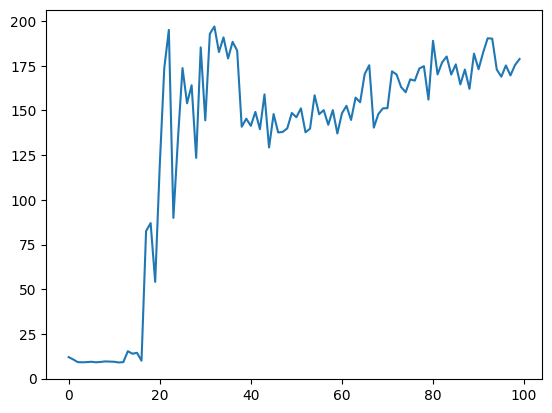

In [24]:
plt.figure()
plt.plot(np.array(mean_rewards))
plt.show()

In [25]:
if False:
    policy.eval() # evaluation mode
    policy.set_eps(0.0)
    collector = ts.data.Collector(policy, ts.env.DummyVectorEnv([lambda: gym.make(env_name, render_mode="human")]))
    result = collector.collect(n_episode=1, render=1./35) # 35 FPS
    print(f"Test reward: {result['rew']}")

Return: 191.0
MoviePy - Building file videos/cartpole-trained.gif with imageio.



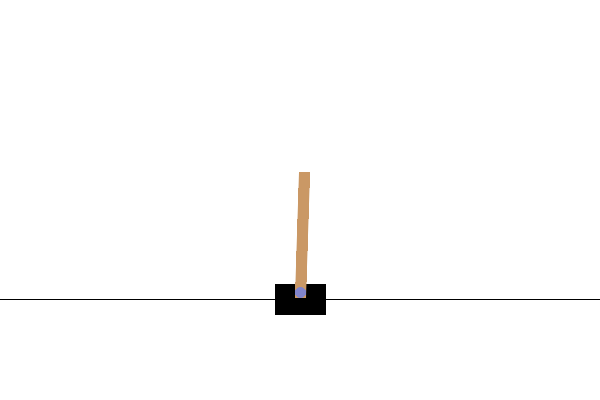

: 

In [26]:
# Evaluation mode
policy.eval() 

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action from the learned policy
    action = policy.forward(batch=ts.data.Batch(obs=np.array([state]), info=None))['act'][0]
    
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward
    
    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-trained.gif"
recorder.make_video(video)
ipython_display(video)